<a href="https://colab.research.google.com/github/benihime91/retinanet_pet_detector/blob/master/colab/train_retinanet_resent50_backbone_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [2]:
# what GPU do we have ?
!nvidia-smi

Thu Sep 24 15:46:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Setup Google-Colab:**

In [3]:
# install dependencies
!pip install --upgrade pytorch-lightning omegaconf wandb --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet

     |████████████████████████████████| 409kB 2.9MB/s 
     |████████████████████████████████| 1.6MB 9.0MB/s 
     |████████████████████████████████| 276kB 19.2MB/s 
     |████████████████████████████████| 2.8MB 20.6MB/s 
     |████████████████████████████████| 829kB 43.1MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 122kB 39.4MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 163kB 41.7MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
     |████████████████████████████████| 952kB 3.0MB/s 


In [ ]:
# Run this cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# clone the github repo:
!git clone --recurse-submodules https://github.com/benihime91/retinanet_pet_detector.git

fatal: destination path 'retinanet_pet_detector' already exists and is not an empty directory.


**Untar the data from Google Drive and save it to VM memory :**

- The cell below unzips the data assuming the `The Oxford-IIIT Pet Dataset` is present in `/content/drive/My Drive/Data/oxford-iiit-pet.tgz.`

- If data is not downloaded download the data from [here](https://www.robots.ox.ac.uk/~vgg/data/pets) and save in it in Google Drive under `/Data/oxford-iiit-pet.tgz`.

In [6]:
# unpacks the data
!tar xf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/

In [7]:
!wandb login "a74f67fd5fae293e301ea8b6710ee0241f595a63"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**Imports:**

In [8]:
import sys
import os
import warnings

os.chdir("/content/retinanet_pet_detector")
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext tensorboard

In [9]:
# Standard Imports
import numpy as np
from omegaconf import OmegaConf, DictConfig
import pandas as pd
import argparse
from PIL import Image

from references import Visualizer
from references.utils import get_label_dict
from train import main

from google.colab import files


pd.set_option("display.max_colwidth",None)

**Preprare Data:**

Before training we need to convert the data into a format that is compatible with the `training pipeline.` We will use `references/data_utils.py` to convert all the xml annotation files into a csv that stores all the annotations and path to the Images.

The resutant csv file will be saved as `/{ouptut_dir}/data-full.csv`.

In [10]:
# Convert xml files to a csv file
!python references/data_utils.py \
    --action create \
    --img_dir "/content/oxford-iiit-pet/images" \
    --annot_dir "/content/oxford-iiit-pet/annotations/xmls" \
    --labels "/content/retinanet_pet_detector/data/labels.names" \
    --output_dir "/content/retinanet_pet_detector/data/"

[09/24 15:47:44 data_utils]: Converting xml files to a csv file
[09/24 15:47:44 data_utils]: Image Directory: /content/oxford-iiit-pet/images
[09/24 15:47:44 data_utils]: Annotation Directory: /content/oxford-iiit-pet/annotations/xmls
[09/24 15:47:44 data_utils]: Path to labels: /content/retinanet_pet_detector/data/labels.names
[09/24 15:47:45 data_utils]: Number of unique classes found: 37
[09/24 15:47:45 data_utils]: csv file saved as /content/retinanet_pet_detector/data/data-full.csv


This is what our data looks like:

In [11]:
df = pd.read_csv("/content/retinanet_pet_detector/data/data-full.csv")
df.head(5)

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/saint_bernard_129.jpg,500,375,240,157,283,196,saint_bernard,28
1,/content/oxford-iiit-pet/images/miniature_pinscher_153.jpg,216,300,25,29,181,179,miniature_pinscher,21
2,/content/oxford-iiit-pet/images/newfoundland_100.jpg,500,333,178,101,265,215,newfoundland,22
3,/content/oxford-iiit-pet/images/german_shorthaired_174.jpg,500,375,113,22,401,266,german_shorthaired,14
4,/content/oxford-iiit-pet/images/saint_bernard_139.jpg,333,500,95,161,188,239,saint_bernard,28


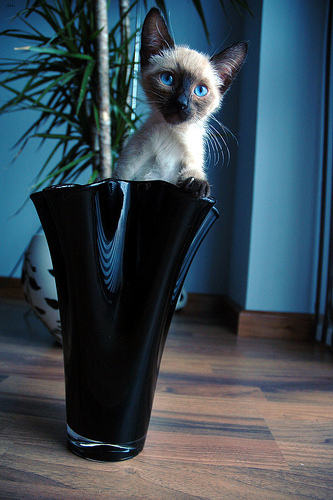

In [12]:
# sanity-check
Image.open(df.filename[100])

We will again the run the script used above but this time we will run this script to create `training`, `validation` & `test` sets from the full dataset.

In [13]:
# Create train, validaiton and test splits in the data
!python references/data_utils.py \
    --action split \
    --csv "/content/retinanet_pet_detector/data/data-full.csv"\
    --valid_size 0.3 \
    --test_size 0.5 \
    --output_dir "/content/retinanet_pet_detector/data/" \
    --seed 123

[09/24 15:47:55 data_utils]: Path to the given csv file : /content/retinanet_pet_detector/data/data-full.csv
[09/24 15:47:55 data_utils]: Generatind train, validation and test splits
[09/24 15:47:56 data_utils]: Files saved to /content/retinanet_pet_detector/data/


We can see that now we have 3 extra files train.csv, valid.csv & test.csv. This files correspond to the `train`,`validation` & `test` datasets respectively.

In [14]:
! ls "/content/retinanet_pet_detector/data"

data-full.csv  labels.names  test.csv  train.csv  valid.csv


In [15]:
# Read in the train and test dataframes
trn_df = pd.read_csv("/content/retinanet_pet_detector/data/train.csv")
tst_df = pd.read_csv("/content/retinanet_pet_detector/data/test.csv")
val_df = pd.read_csv("/content/retinanet_pet_detector/data/valid.csv")

In [16]:
trn_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/saint_bernard_129.jpg,500,375,240,157,283,196,saint_bernard,28
1,/content/oxford-iiit-pet/images/miniature_pinscher_153.jpg,216,300,25,29,181,179,miniature_pinscher,21
2,/content/oxford-iiit-pet/images/newfoundland_100.jpg,500,333,178,101,265,215,newfoundland,22
3,/content/oxford-iiit-pet/images/german_shorthaired_174.jpg,500,375,113,22,401,266,german_shorthaired,14
4,/content/oxford-iiit-pet/images/english_cocker_spaniel_174.jpg,352,500,83,19,284,233,english_cocker_spaniel,12


In [17]:
tst_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/saint_bernard_139.jpg,333,500,95,161,188,239,saint_bernard,28
1,/content/oxford-iiit-pet/images/keeshond_123.jpg,500,333,185,22,401,236,keeshond,18
2,/content/oxford-iiit-pet/images/newfoundland_126.jpg,443,500,227,52,380,217,newfoundland,22
3,/content/oxford-iiit-pet/images/great_pyrenees_121.jpg,500,410,186,32,355,170,great_pyrenees,15
4,/content/oxford-iiit-pet/images/Sphynx_170.jpg,500,333,132,27,298,200,sphynx,33


In [18]:
val_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/chihuahua_128.jpg,300,225,94,35,235,136,chihuahua,10
1,/content/oxford-iiit-pet/images/great_pyrenees_12.jpg,398,480,179,234,280,320,great_pyrenees,15
2,/content/oxford-iiit-pet/images/newfoundland_186.jpg,500,500,254,25,410,175,newfoundland,22
3,/content/oxford-iiit-pet/images/Russian_Blue_18.jpg,500,342,149,14,325,199,russian_blue,27
4,/content/oxford-iiit-pet/images/British_Shorthair_127.jpg,322,500,49,130,264,355,british_shorthair,9


**View some images from the datasets:**

In [19]:
# Read in the Labes dictionary 
# and initializer the visualizer to view images with bboxes
label_dict = get_label_dict("/content/retinanet_pet_detector/data/labels.names")
vis = Visualizer(label_dict)

[09/24 15:48:15 references.display_preds]: visualizer initialized


In [20]:
# These are the label
label_dict

{0: 'abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'bengal',
 6: 'birman',
 7: 'bombay',
 8: 'boxer',
 9: 'british_shorthair',
 10: 'chihuahua',
 11: 'egyptian_mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'maine_coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'ragdoll',
 27: 'russian_blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'siamese',
 33: 'sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

In [21]:
np.random.seed(123)

def display_random_image(data):
    """
    Fn to display a random using the `Visualizer`
    from the given pandas dataframe. The bounding boxes are also
    drawn over the image.

    Args:
     data (`pd.dataframe`): A `pandas dataframe` where filename corresponds to 
                            the image path and bbox co-ordinates are stored in 
                            `[xmin,xmax,ymin,ymax]` & class_names (`int`) are 
                            stored in `[labels]`.
    """
    idx = np.random.randint(0, len(df))
    image_id = df.filename[idx]
    locs = df.loc[df.filename == image_id]
    boxes = locs[['xmin','ymin','xmax','ymax']].values
    labels = locs['labels'].values
    vis.draw_bboxes(image_id, boxes, labels)

[09/24 15:48:24 references.display_preds]: Found 1 bounding box(s) on the given image


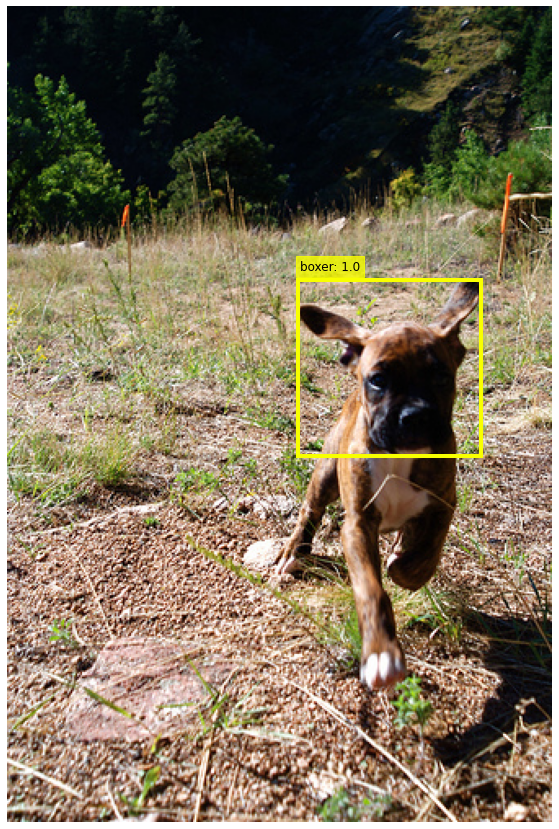

In [22]:
# Display a random Image from the Train dataset
display_random_image(data=trn_df)

[09/24 15:48:24 references.display_preds]: Found 1 bounding box(s) on the given image


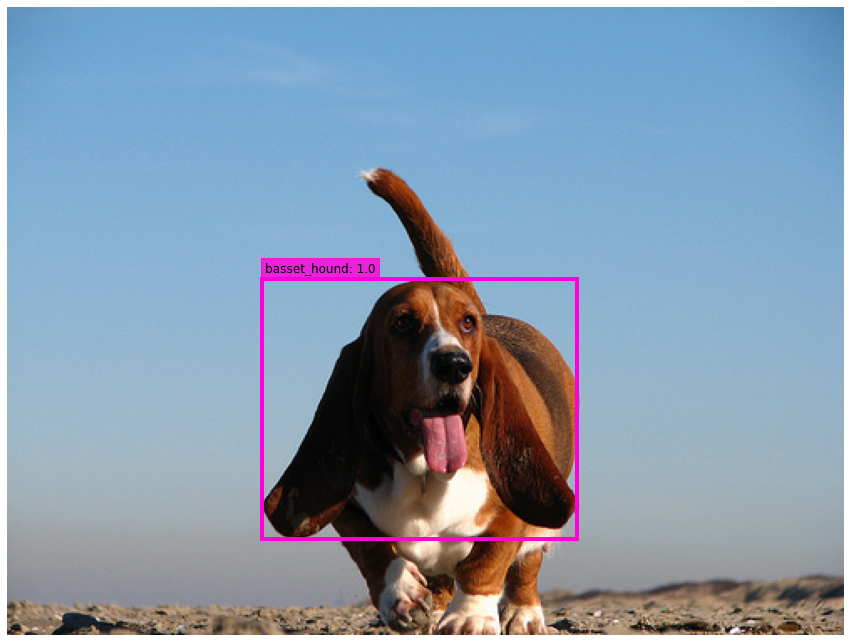

In [23]:
# Display a random Image from the test dataset
display_random_image(data=tst_df)

[09/24 15:48:25 references.display_preds]: Found 1 bounding box(s) on the given image


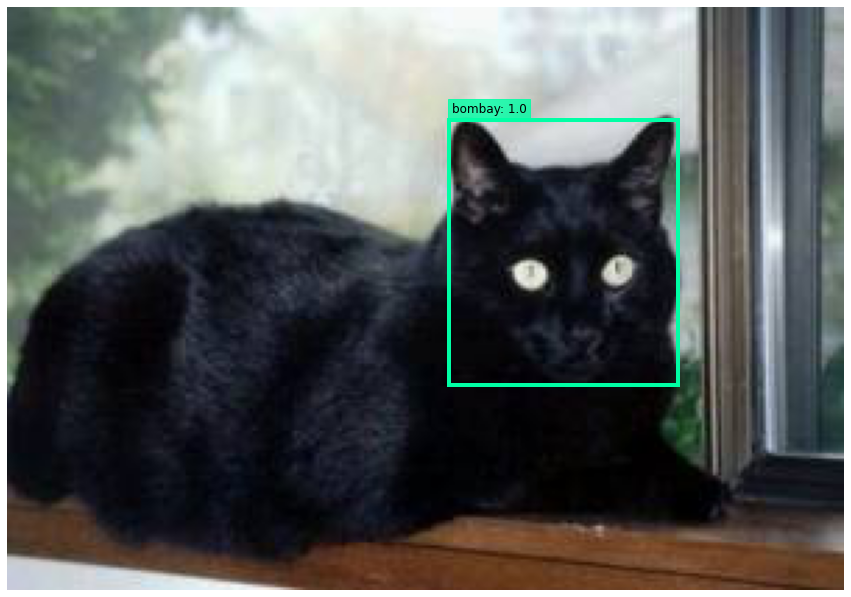

In [24]:
# Display a random Image from the validation dataset
display_random_image(data=val_df)

**Load (or Modify) the Config file:**

In [25]:
import time

# load the config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")

# -------------------------------------------- #
# Modify some config parameters:
# -------------------------------------------- #

# since we will use the resnet50-backbone retinanet to train model
config.model.backbone_kind = "resnet50" 
# update the paths to the train, validation and test csv files
config.hparams.train_csv = "/content/retinanet_pet_detector/data/train.csv"
config.hparams.valid_csv = "/content/retinanet_pet_detector/data/valid.csv"
config.hparams.test_csv  = "/content/retinanet_pet_detector/data/test.csv"
# update the batch size for the train dataset
config.hparams.train_batch_size = 2
# path to where checkpoint and final weights are to saved
config.trainer.model_checkpoint.params.filepath = "/content/drive/My Drive/pets"
# path to where the training logs are to saved for TensorBoard Logger
config.trainer.logger.params.save_dir = "/content/logs/"
# Let's modify the scheduler
config.hparams.scheduler.class_name = "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts"
config.hparams.scheduler.params = {"T_0": 10, "T_mult": 2}
config.hparams.scheduler.interval = "step"
# modify optimier
config.hparams.optimizer.params.lr = 0.002
config.hparams.optimizer.params.weight_decay = 0.001
# epochs to train for
config.trainer.flags.max_epochs = 80
# early stopping patience
config.trainer.early_stopping.params.patience = 3

# Since i will be using wandb logger for this experiment:
config.trainer.logger = {
    "class_name": "pytorch_lightning.loggers.wandb.WandbLogger",
    "params":{
        "name" : f"[{time.strftime('%m/%d %H:%M:%S')}]-{config.model.backbone_kind}",
        "version": 0,
        "anonymous": True,
        "project": "retinanet-oxford-pets"
    }
}

# Save the modified config file
OmegaConf.save(config=config, f="/content/retinanet_pet_detector/main.yaml")

In [26]:
# Load and view the modified config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")
# let's take a look at out config file
print(OmegaConf.to_yaml(config))

model:
  backbone_kind: resnet50
  num_classes: 37
  freeze_bn: true
  min_size: 800
  max_size: 1600
hparams:
  train_csv: /content/retinanet_pet_detector/data/train.csv
  train_batch_size: 2
  valid_csv: /content/retinanet_pet_detector/data/valid.csv
  valid_batch_size: 32
  test_csv: /content/retinanet_pet_detector/data/test.csv
  test_batch_size: 32
  iou_types: bbox
  dataloader:
    pin_memory: true
    num_workers: 0
  optimizer:
    class_name: torch.optim.SGD
    params:
      lr: 0.002
      weight_decay: 0.001
      momentum: 0.9
  scheduler:
    class_name: torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
    params:
      T_0: 10
      T_mult: 2
    interval: step
    frequency: 1
  augmentation:
    train:
    - class_name: albumentations.HorizontalFlip
      params:
        p: 0.5
    - class_name: albumentations.ToGray
      params:
        p: 0.25
    - class_name: albumentations.CLAHE
      params:
        p: 0.5
    - class_name: albumentations.ToFloat
      para

### **Train, Validation & Test :**

In colab use the main function to train otherwise Lightning progress bar goes mad, this issue is highlighted [here]( https://github.com/PyTorchLightning/pytorch-lightning/issues/721). 

The `main` function accepts `argparse` arguments so we will first define a `Dictionary` with the args and convert it to `argparse.Namespace` instance

In [ ]:
# Creat argument dictionary
d = {"config": "/content/retinanet_pet_detector/main.yaml", "verbose": 0}
# Creat argument dictionary
args = DictConfig(d)
print(args.pretty())

config: /content/retinanet_pet_detector/main.yaml
verbose: 0



#### **Start Train :**

In [ ]:
# run the main function
# set a seed number to ensure results are reproducible
main(args, seed=123)

[09/24 05:21:46 train]: Random seed = 123


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



[09/24 05:21:48 train]: Backbone : resnet50
[09/24 05:21:48 train]: Score Threshold : 0.05
[09/24 05:21:48 train]: NMS Threshold : 0.5
[09/24 05:21:48 train]: Num Classes : 37
[09/24 05:21:48 train]: Image Resize parameters: smallest_image_size = 800
[09/24 05:21:48 train]: Image Resize parameters: maximum_image_size = 1600


GPU available: True, used: True
[09/24 05:21:48] lightning INFO: GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[09/24 05:21:48] lightning INFO: TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
[09/24 05:21:48] lightning INFO: CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
[09/24 05:21:48] lightning INFO: Using native 16bit precision.


[09/24 05:21:48 references.lightning]: Augmentations used in training: ['HorizontalFlip', 'ToGray', 'CLAHE', 'ToFloat', 'ToTensorV2']
[09/24 05:21:48 references.lightning]: Serialized train dataset from /content/retinanet_pet_detector/data/train.csv
[09/24 05:21:48 references.lightning]: Serialized dataset takes 0.22 MiB
[09/24 05:21:48 references.lightning]: Serialized validation dataset from /content/retinanet_pet_detector/data/valid.csv
[09/24 05:21:48 references.lightning]: Serialized dataset takes 0.05 MiB
[09/24 05:21:48 references.lightning]: Serialized test dataset from /content/retinanet_pet_detector/data/test.csv
[09/24 05:21:48 references.lightning]: Serialized dataset takes 0.05 MiB
[09/24 05:22:02 references.lightning]: Optimizer Loaded : SGD
[09/24 05:22:02 references.lightning]: Scheduler Loaded : CosineAnnealingWarmRestarts


wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200924_052202-347nai9w
wandb: Syncing run [09/24 05:21:20]-resnet50



creating index...
index created!
[09/24 05:22:06 references.lightning]: Training on 2580 images
[09/24 05:22:06 references.lightning]: Starting training from iteration 0 : 


creating index...
index created!
[09/24 07:12:56 references.lightning]: Inference on 553 images


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.04s).
[09/24 07:16:58 references.lightning]: Evaluation results: 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
[09/24 08:51:27 references.lightning]: Evaluation results: 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.854
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
[09/24 10:24:26 references.lightning]: Evaluation results: 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.05s).
[09/24 11:55:44 references.lightning]: Evaluation results: 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
[09/24 13:26:59 references.lightning]: Evaluation results: 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.04s).
[09/24 14:57:19 references.lightning]: Evaluation results: 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]

#### **Runtime got disconnected so `resume from previous checkpoint`:**

In [29]:
# load the config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")

# -------------------------------------------- #
# Modify some config parameters:
# -------------------------------------------- #

# since we will use the resnet50-backbone retinanet to train model
config.model.backbone_kind = "resnet50" 
# update the paths to the train, validation and test csv files
config.hparams.train_csv = "/content/retinanet_pet_detector/data/train.csv"
config.hparams.valid_csv = "/content/retinanet_pet_detector/data/valid.csv"
config.hparams.test_csv  = "/content/retinanet_pet_detector/data/test.csv"
# update the batch size for the train dataset
config.hparams.train_batch_size = 2
# path to where checkpoint and final weights are to saved
config.trainer.model_checkpoint.params.filepath = "/content/drive/My Drive/pets"

# Let's modify the scheduler
config.hparams.scheduler.class_name = "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts"
config.hparams.scheduler.params = {"T_0": 10, "T_mult": 2}
config.hparams.scheduler.interval = "step"
# modify optimier
config.hparams.optimizer.params.lr = 0.002
config.hparams.optimizer.params.weight_decay = 0.001
# epochs to train for
config.trainer.flags.max_epochs = 80
# early stopping patience
config.trainer.early_stopping.params.patience = 3

# add checkpoint path
config.trainer.flags.resume_from_checkpoint = "/content/drive/My Drive/pets/epoch=59.ckpt"

# Since i will be using wandb logger for this experiment:
nm = config.trainer.flags.resume_from_checkpoint.split(os.path.sep)[-1].split(".")[0]
config.trainer.logger = {
    "class_name": "pytorch_lightning.loggers.wandb.WandbLogger",
    "params":{
        "name" : f"[{time.strftime('%m/%d %H:%M:%S')}]-{config.model.backbone_kind}-[{nm}]",
        "version": 0,
        "anonymous": True,
        "project": "retinanet-oxford-pets"
    }
}


# Save the modified config file
OmegaConf.save(config=config, f="/content/retinanet_pet_detector/main.yaml")

In [30]:
# Load and view the modified config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")
# let's take a look at out config file
print(OmegaConf.to_yaml(config))

model:
  backbone_kind: resnet50
  num_classes: 37
  freeze_bn: true
  min_size: 800
  max_size: 1600
hparams:
  train_csv: /content/retinanet_pet_detector/data/train.csv
  train_batch_size: 2
  valid_csv: /content/retinanet_pet_detector/data/valid.csv
  valid_batch_size: 32
  test_csv: /content/retinanet_pet_detector/data/test.csv
  test_batch_size: 32
  iou_types: bbox
  dataloader:
    pin_memory: true
    num_workers: 0
  optimizer:
    class_name: torch.optim.SGD
    params:
      lr: 0.002
      weight_decay: 0.001
      momentum: 0.9
  scheduler:
    class_name: torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
    params:
      T_0: 10
      T_mult: 2
    interval: step
    frequency: 1
  augmentation:
    train:
    - class_name: albumentations.HorizontalFlip
      params:
        p: 0.5
    - class_name: albumentations.ToGray
      params:
        p: 0.25
    - class_name: albumentations.CLAHE
      params:
        p: 0.5
    - class_name: albumentations.ToFloat
      para

In [ ]:
# Creat argument dictionary
d = {"config": "/content/retinanet_pet_detector/main.yaml", "verbose": 0}
# Creat argument dictionary
args = DictConfig(d)
print("[INFO] Config:\n", args.pretty())

# run the main function
# set a seed number to ensure results are reproducible
main(args, seed=123)

[INFO] Config:
 config: /content/retinanet_pet_detector/main.yaml
verbose: 0

[09/24 15:50:27 train]: Random seed = 123


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



[09/24 15:50:29 train]: Backbone : resnet50
[09/24 15:50:29 train]: Score Threshold : 0.05
[09/24 15:50:29 train]: NMS Threshold : 0.5
[09/24 15:50:29 train]: Num Classes : 37
[09/24 15:50:29 train]: Image Resize parameters: smallest_image_size = 800
[09/24 15:50:29 train]: Image Resize parameters: maximum_image_size = 1600


GPU available: True, used: True
[09/24 15:50:29] lightning INFO: GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[09/24 15:50:29] lightning INFO: TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
[09/24 15:50:29] lightning INFO: CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
[09/24 15:50:29] lightning INFO: Using native 16bit precision.


[09/24 15:50:29 references.lightning]: Augmentations used in training: ['HorizontalFlip', 'ToGray', 'CLAHE', 'ToFloat', 'ToTensorV2']
[09/24 15:50:29 references.lightning]: Serialized train dataset from /content/retinanet_pet_detector/data/train.csv
[09/24 15:50:29 references.lightning]: Serialized dataset takes 0.22 MiB
[09/24 15:50:30 references.lightning]: Serialized validation dataset from /content/retinanet_pet_detector/data/valid.csv
[09/24 15:50:30 references.lightning]: Serialized dataset takes 0.05 MiB
[09/24 15:50:30 references.lightning]: Serialized test dataset from /content/retinanet_pet_detector/data/test.csv
[09/24 15:50:30 references.lightning]: Serialized dataset takes 0.05 MiB
[09/24 15:50:43 references.lightning]: Optimizer Loaded : SGD
[09/24 15:50:43 references.lightning]: Scheduler Loaded : CosineAnnealingWarmRestarts


wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200924_155044-3h3vr10o
wandb: Syncing run [09/24 15:50:15]-resnet50-[epoch=59]



creating index...
index created!
[09/24 15:50:52 references.lightning]: Training on 2580 images
[09/24 15:50:52 references.lightning]: Starting training from iteration 77400 : 


**Wandb Logs:**

<img src="https://www.dropbox.com/s/3dzihab85jcacfe/wandb_logs.png?raw=1" alt="wandb_logs">

## **Inference with saved weights:**

To do inference we need to modify or create a config file for inference. The config file for inference should contain the following:
- `model_backbone` (`str`) : resnet backbone used for the retinanet model.
- `url` (`str`) : url or the path to where weights are saved.
- `num_classes` (`int`) : total number of unique classes.

We will save this `config` file at : `/content/retinanet_pet_detector/config/resnet50.yaml`

**Instantiate config for inference:**

In [ ]:
# we used a resnet34 model so,
# we will set the backbone to be `renet34`
backbone = "resnet34"
# path to where model weights are saved
url = "/content/drive/My Drive/retianet-pets/weights.pth"
# total number of classes
num_classes = 37

d = {"model_backbone": backbone, "url": url, "num_classes": num_classes}
conf = DictConfig(d)

# Save the config File
fname = "/content/retinanet_pet_detector/config/resnet34.yaml"
OmegaConf.save(config=conf, f=fname)

# Print out the config File
print(OmegaConf.to_yaml(conf))

In [ ]:
# path to the ocnfig file
config = "/content/retinanet_pet_detector/config/resnet34.yaml"

**Run Inference:**

In [ ]:
!python inference.py \
    --config {config} \
    --image {tst_df.filename[100]} \
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_1.png" \

In [ ]:
Image.open("/content/res_1.png")

In [ ]:
!python inference.py \
    --config {config} \
    --image {tst_df.filename[800]} \
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_2.png" \

In [ ]:
Image.open("/content/res_2.png")

**The following cells run inference on user uploaded image:**

In [ ]:
uploaded = files.upload()
fname = list(uploaded.keys())[0]

In [ ]:
!python inference.py \
    --config {config}\
    --image {fname} \
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_3.png" \

In [ ]:
Image.open("/content/res_3.png")